# Writing and Optimizing Fault Tolerant Chemistry Algorithms with Qualtran 
<p style="text-align: center;"><a href="mailto:fmalone@google.com">Fionn Malone</a></p>



In this tutorial we will outline how one might go about writing a **new** algorithm in qualtran, using the block encoding of the chemistry Hamiltonian as an example. We will attempt to implement the most basic block encoding of the second quantized chemistry Hamiltonian
$$
H = \sum_\sigma \sum_{pq}^{N/2} T_{pq} a_{p\sigma}^\dagger a_{q\sigma}
+
\frac{1}{2}\sum_{\alpha\beta}
\sum_{pqrs}^{N/2}
V_{pqrs} a_{p\alpha}^\dagger a_{q\alpha} a_{r\beta}^\dagger a_{s\beta} ,
$$
where $a_{p\sigma}$ ($a_{q\sigma}^\dagger$) annihilate (create) an electron in the
$p$-th orbital of spin $\sigma$. The $V_{pqrs}$ tensor contains $O(N^4)$ elements and represents a bottleneck for block encoding second quantized Hamiltonians. Our goal will be to 

1. Understand how to write algorithms in bloqs, including deferring the implementation of certain unimportant details.
2. Develop a feel for the most expensive parts of an algorithm.
3. Understand some basic principles on how to optimize an algorithm, including the trade-offs which arise.
4. Compare our naive algorithm to those implemented in qualtran.

We will focus on building a Prepare bloq, as [select](sparse/select_bloq.py) has little to optimize.

## Simple Strategy
We will follow a simple strategy for building up algorithms in qualtran:

1. Define the signature of your bloq.
2. Define the `build_call_graph` method using more primitive bloqs implemented in qualtran.
3. Think about other implementations and adjust step 2 if necessary.
4. Wire up your bloq using by defining a `build_composite_bloq` method.
5. Check that the costs of step 4 == the costs of step 2

## Prepare

To begin, let's write a state preparation bloq using the [PrepareOracle](../block_encoding/lcu_select_and_prepare.py) abstract base class, which specifies groups of registers we **must** define.  The goal will be to prepare the state

$$
\mathrm{Prepare}|0\rangle^{\otimes 4 \log(N/2) + 3} = \sum_{\sigma}\sum_{pq} \sqrt{\frac{|T_{pq}|}{\lambda}} |\theta_{pq}\rangle|pq\sigma\rangle|000\rangle + \sum_{\alpha\beta}\sum_{pqrs}\sqrt{\frac{|V_{pqrs}|}{2\lambda}}|\theta_{pqrs}\rangle|pq\alpha\rangle|rs\beta\rangle
$$
Here the registers $p, q, r$ and $s$ are of size $\log(N/2)$ and the spin and sign ($\theta$) registers are single qubits. It helps to start by just specifying the signature of the bloq:

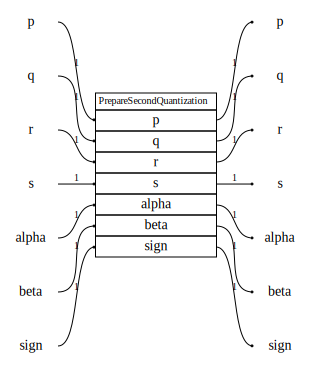

In [1]:
from functools import cached_property
from typing import Tuple
from attrs import frozen
from qualtran import Register, BoundedQUInt, QBit, QAny

from qualtran.drawing import show_bloq
from qualtran.bloqs.block_encoding.lcu_select_and_prepare import PrepareOracle

@frozen
class PrepareSecondQuantization(PrepareOracle):

    num_spin_orb: int

    @cached_property
    def selection_registers(self) -> Tuple[Register, ...]:
        bitsize = (self.num_spin_orb // 2 - 1).bit_length()
        return (
            Register('p', BoundedQUInt(bitsize=bitsize, iteration_length=self.num_spin_orb//2)),
            Register('q', BoundedQUInt(bitsize=bitsize, iteration_length=self.num_spin_orb//2)),
            Register('r', BoundedQUInt(bitsize=bitsize, iteration_length=self.num_spin_orb//2)),
            Register('s', BoundedQUInt(bitsize=bitsize, iteration_length=self.num_spin_orb//2)),
            Register('alpha', BoundedQUInt(bitsize=1)),
            Register('beta', BoundedQUInt(bitsize=1)),
            Register('sign', BoundedQUInt(bitsize=1)),
        )

    # defer definition of junk registers until you actually need to implement a decomposition.

show_bloq(PrepareSecondQuantization(4))

Ok! That looks about right as a signature. Next we can think about how to implement the state preparation, which, for all second quantized algorithms follows the alias sampling procedure from the [Linear T paper](https://arxiv.org/abs/1805.03662). The general procedure is

1. Prepare a uniform superposition over the selection registers ($p,q,r,s,\alpha,\beta$).
2. Output a qrom with alt/keep values, with the qrom indexed by $p, q, r$ and $s$ (typically the chemistry inputs are spin-independent)
3. Perform an inequality test between the keep register and a register in a uniform superposition.
4. Swap the alt values dependent on controlled on the result of the inequality test.

In [2]:
from typing import Set, Optional
from qualtran.bloqs.arithmetic.comparison import LessThanEqual
from qualtran.bloqs.basic_gates.swap import CSwap
from qualtran.resource_counting import SympySymbolAllocator, BloqCountT
from qualtran.bloqs.state_preparation import PrepareUniformSuperposition
from qualtran.bloqs.chemistry.black_boxes import QROAM


@frozen
class PrepareSecondQuantization(PrepareOracle):

    num_spin_orb: int
    num_bits_state_prep: int = 16
    qroam_block_size: Optional[int] = None

    @cached_property
    def selection_registers(self) -> Tuple[Register, ...]:
        bitsize = (self.num_spin_orb // 2 - 1).bit_length()
        return (
            Register('p', BoundedQUInt(bitsize=bitsize, iteration_length=self.num_spin_orb // 2)),
            Register('q', BoundedQUInt(bitsize=bitsize, iteration_length=self.num_spin_orb // 2)),
            Register('r', BoundedQUInt(bitsize=bitsize, iteration_length=self.num_spin_orb // 2)),
            Register('s', BoundedQUInt(bitsize=bitsize, iteration_length=self.num_spin_orb // 2)),
            Register('alpha', BoundedQUInt(1)),
            Register('beta', BoundedQUInt(1)),
            Register('sign', BoundedQUInt(1)),
        )

    def build_call_graph(self, ssa: 'SympySymbolAllocator') -> Set['BloqCountT']:
        # 1. Prepare a uniform superposition over p, q, r and s
        bitsize = (self.num_spin_orb // 2 - 1).bit_length()
        # a factor of 4 here for p, q, r, and s
        cost_uni_prep = (PrepareUniformSuperposition(self.num_spin_orb//2), 4)
        # we are free to ignore certain costs at this point, so let's forget
        # about the Hadamards on the alpha/beta registers.
        # 2. Output a QROM
        # we have N^4 elements to output
        data_size = (self.num_spin_orb // 2)**2 + (self.num_spin_orb // 2) ** 4
        # We need the alt values for p,q,r,s, the theta values and alt values
        # for theta, and the keep values (for alias sampling.)
        target_bitsize = sum((bitsize,)*4 + (1, 1, self.num_bits_state_prep))
        # here we are using a "black box" QROAM which has formulaic costs for
        # qrom or qroam. Setting qroam_block_size=1 ensures we get a QROM.
        cost_qrom = (QROAM(data_size, target_bitsize, qroam_block_size=self.qroam_block_size), 1)
        # 3. inequality test the keep register 
        cost_ineq = (LessThanEqual(self.num_bits_state_prep, self.num_bits_state_prep), 1)
        # 4. swap the alt values, the sign bit does not need a swap.
        cost_swap = (CSwap(bitsize), 4)
        return {cost_uni_prep, cost_qrom, cost_ineq, cost_swap}

At this point we can check that the scaling of our "algorithm" is correct (i.e. $O(N^4)$)

Text(0, 0.5, '$T$ count')

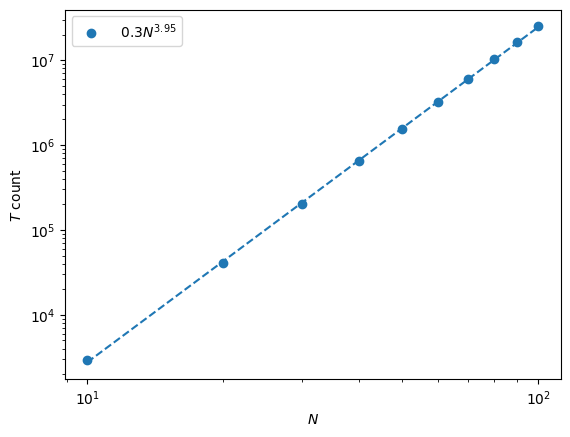

In [3]:
import numpy as np
from qualtran.bloqs.basic_gates import TGate
from qualtran.bloqs.chemistry.chem_tutorials import plot_linear_log_log
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
basis_vals = np.linspace(10, 100, 10, dtype=int)
tcounts = [PrepareSecondQuantization(int(n), qroam_block_size=1).call_graph()[1][TGate()] for n in basis_vals]
plot_linear_log_log(ax, basis_vals, np.array(tcounts))
ax.set_xlabel("$N$")
ax.set_ylabel("$T$ count")

Good. Now we can make our first optimization. What happens if we use QROAM instead of QROM? To do so we can set the qrom blocking factor to be $>1$.

Text(0, 0.5, '$T$ count')

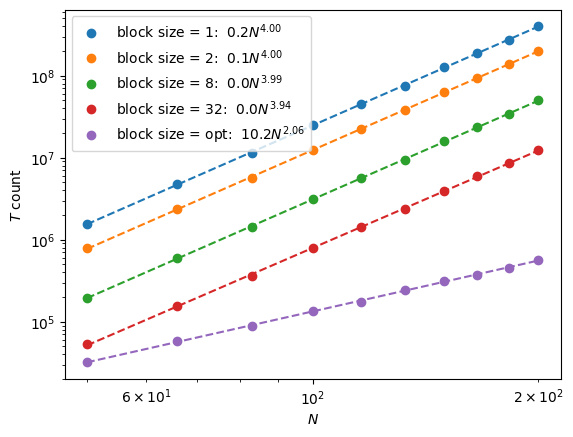

In [4]:
fig, ax = plt.subplots()
basis_vals = np.linspace(50, 200, 10, dtype=int)
for ib, block_size in enumerate([1, 2, 8, 32, None]):
    tcounts = [PrepareSecondQuantization(int(n), qroam_block_size=block_size).call_graph()[1][TGate()] for n in basis_vals]
    if block_size is None:
        block_size = 'opt'
    plot_linear_log_log(ax, basis_vals, np.array(tcounts), label=f'block size = {block_size}: ', color=f'C{ib}')
ax.set_xlabel("$N$")
ax.set_ylabel("$T$ count")

So using the optimal block size (corresponding to None here), allows us to achieve an $O(N^2)$ scaling with the system size.
Question: why does using a constant block size not affect the asymptotic scaling? 

But wait! We have made a mistake, QROAM requires a single index as a selection register, thus we need to form a contiguous index from $(p, q, r, s)$ as

$$
l = p (N/2)^3 + q (N/2)^2 + r (N/2) + s
$$

Could this be a significant cost? It requires three multiplications (the powers of $N$ can be precomputed and loaded as classical values) and 4 additions. Roughly this costs $3 (n^2 - n) + 4\times(n-1) = 3n^2 + n - 1$ Toffolis, where $n = \log \lceil N/2\rceil$. Given that this cost is logarithmic in $N$ and our QROAM costs is quadratic in $N$, it is totally negligible.

### Exercises:
1. Figure out where these arithmetic estimates came from. Hint: arithmetic.
2. Work out the precise cost for multiplying a classical value by an integer and implement these as bloqs.
3. Add these bloqs to your call_graph and check our logic about it being negligible. How negligible is negligible?

## Wiring up

At this point you might be suspicious of this QROAM bloq, or that just defining a call_graph is a little underwhelming. So let us get into the more unpleasant details and write some thing that will (nearly) compile down to a circuit. 

First let's write a placeholder bloq for our complicated contiguous register gate.

In [5]:
from qualtran import Signature, Bloq
from qualtran.bloqs.basic_gates import Toffoli
from qualtran.cirq_interop.t_complexity_protocol import TComplexity


@frozen
class ContiguousIndexFourD(Bloq):
    bitsize: int
    output_bitsize: int

    @cached_property
    def signature(self) -> Signature:
        return Signature.build(
            p=self.bitsize, q=self.bitsize, r=self.bitsize, s=self.bitsize, l=self.output_bitsize
        )

    # Exercise (easy): wire up this bloq
    # Exercise (harder): test that your decomposition is correct! Some of the
    #   arithmetic sub-bloqs will require more details!
    # Exercise (easy): add an on_classical_vals method
    # Exercise: Send a PR for this bloq

    def t_complexity(self) -> TComplexity:
        return TComplexity(t=4 * (3 * (self.bitsize**2 - self.bitsize) + 4 * (self.bitsize - 1))) 

    def build_call_graph(self, ssa: 'SympySymbolAllocator') -> Set['BloqCountT']:
        # Exercise: Use existing bloqs in qualtran to give this call graph a little more spice.
        cost = 3 * (self.bitsize**2 - self.bitsize) + 4 * (self.bitsize - 1)
        return {(Toffoli(), cost)}

Next, we can write our bloq decomposition, using existing primitives / algorithms in qualtran. Be on the lookout, we've sprinkled in a few errors. 

In [6]:
from attrs import field
from typing import Dict
from qualtran import SoquetT, BloqBuilder, Register

from qualtran.bloqs.state_preparation import PrepareUniformSuperposition
from qualtran.bloqs.data_loading.select_swap_qrom import SelectSwapQROM, find_optimal_log_block_size
from qualtran.bloqs.basic_gates import CSwap, Hadamard, OnEach


@frozen
class PrepareSecondQuantizationDetailed(PrepareOracle):

    num_spin_orb: int
    alt_pqrs: Tuple[int, ...] = field(repr=False)
    keep: Tuple[int, ...] = field(repr=False)
    num_bits_state_prep: int = 16
    qroam_block_size: Optional[int] = None

    @cached_property
    def selection_registers(self) -> Tuple[Register, ...]:
        ns = self.num_spin_orb // 2
        bitsize = (ns - 1).bit_length()
        data_size = (ns ** 2 + ns**4)
        contg_reg_size = (data_size - 1).bit_length()
        return (
            Register('p', BoundedQUInt(bitsize=bitsize, iteration_length=self.num_spin_orb // 2)),
            Register('q', BoundedQUInt(bitsize=bitsize, iteration_length=self.num_spin_orb // 2)),
            Register('r', BoundedQUInt(bitsize=bitsize, iteration_length=self.num_spin_orb // 2)),
            Register('s', BoundedQUInt(bitsize=bitsize, iteration_length=self.num_spin_orb // 2)),
            Register(
                'l', BoundedQUInt(bitsize=contg_reg_size, iteration_length=data_size),
            ),
            Register('alpha', BoundedQUInt(1)),
            Register('beta', BoundedQUInt(1)),
            Register('sigma', BoundedQUInt(bitsize=self.num_bits_state_prep)),
        )

    @cached_property
    def junk_registers(self) -> Tuple[Register, ...]:
        alt_bitsize = (self.num_spin_orb // 2 - 1).bit_length()
        return (
            Register('alt_pqrs', QAny(alt_bitsize), shape=(4,)),
            Register('keep', QAny(self.num_bits_state_prep)),
            Register('less_than', QBit()),
        )

    def build_composite_bloq(
        self,
        bb: 'BloqBuilder',
        p: 'SoquetT',
        q: 'SoquetT',
        r: 'SoquetT',
        s: 'SoquetT',
        l: 'SoquetT',
        alpha: 'SoquetT',
        beta: 'SoquetT',
        sigma: 'SoquetT',
        alt_pqrs: 'SoquetT',
        keep: 'SoquetT',
        less_than: 'SoquetT',
    ) -> Dict[str, 'SoquetT']:
        # 1. Prepare \sum_d |d\rangle
        p = bb.add(PrepareUniformSuperposition(self.num_spin_orb // 2), target=p)
        q = bb.add(PrepareUniformSuperposition(self.num_spin_orb // 2), target=q)
        r = bb.add(PrepareUniformSuperposition(self.num_spin_orb // 2), target=r)
        s = bb.add(PrepareUniformSuperposition(self.num_spin_orb // 2), target=s)
        # 2. Make a contiguous register from our 4-registers
        n_n = (self.num_spin_orb // 2 - 1).bit_length()
        creg_bitsize = self.signature.get_left('l').bitsize
        p, q, r, s, l = bb.add(ContiguousIndexFourD(n_n, creg_bitsize), p=p, q=q, r=r, s=s, l=l)
        # 3. Output the alt / keep values using QRO(A)M. The target bitsizes are
        # the sizes of the qrom data sets. The alt pqrs values have bitsize n_n
        # and the keep register has bitsize of num_bits_state_prep, which
        # controls the precision of the alias sampling.
        target_bitsizes = (n_n,) * 4 + (self.num_bits_state_prep,)
        ns = self.num_spin_orb // 2
        data_size = ns ** 2 + ns**4
        log_block_size = find_optimal_log_block_size(data_size, sum(target_bitsizes))
        qroam = SelectSwapQROM.build_from_data(
            self.alt_pqrs[0],
            self.alt_pqrs[1],
            self.alt_pqrs[2],
            self.alt_pqrs[3],
            self.keep,
            target_bitsizes=target_bitsizes,
            log_block_sizes=[log_block_size],
        )
        (l, alt_pqrs[0], alt_pqrs[1], alt_pqrs[2], alt_pqrs[3], keep) = bb.add(
            qroam,
            selection=l,
            target0_=alt_pqrs[0],
            target1_=alt_pqrs[1],
            target2_=alt_pqrs[2],
            target3_=alt_pqrs[3],
            target4_=keep,
        )
        # 4. prepare uniform superposition over sigma
        sigma = bb.add(OnEach(self.num_bits_state_prep, Hadamard()), q=sigma)
        # 5. inequality test for alias sampling
        lte_bloq = LessThanEqual(self.num_bits_state_prep, self.num_bits_state_prep)
        keep, sigma, less_than = bb.add(lte_bloq, x=keep, y=sigma, target=less_than)
        # 6. swap the ind and alt_pqrs values
        less_than, alt_pqrs[0], p = bb.add(CSwap(n_n), ctrl=less_than, x=alt_pqrs[0], y=p)
        less_than, alt_pqrs[1], q = bb.add(CSwap(n_n), ctrl=less_than, x=alt_pqrs[1], y=q)
        less_than, alt_pqrs[2], r = bb.add(CSwap(n_n), ctrl=less_than, x=alt_pqrs[2], y=r)
        less_than, alt_pqrs[3], s = bb.add(CSwap(n_n), ctrl=less_than, x=alt_pqrs[3], y=s)
        # 7. invert the comparator
        keep, sigma, less_than = bb.add(lte_bloq, x=keep, y=sigma, target=less_than)
        return {
            'p': p,
            'q': q,
            'r': r,
            's': s,
            'l': l,
            'alpha': alpha,
            'beta': beta,
            'sigma': sigma,
            'alt_pqrs': alt_pqrs,
            'keep': keep,
            'less_than': less_than,
        }

Let's generate an instance. We need alt and keep values for our register so let's generate those as follows:

In [7]:
from qualtran.linalg.lcu_util import preprocess_lcu_coefficients_for_reversible_sampling


def build_alt_keep_vals(tpq, eris, num_spin_orb, num_bits_state_prep):
    # Get some random hamiltonian matrix elements
    lcu_coeffs = np.concatenate((tpq.ravel(), eris.ravel()))
    alt, keep, mu = preprocess_lcu_coefficients_for_reversible_sampling(
        np.abs(lcu_coeffs), epsilon=2**-num_bits_state_prep / len(lcu_coeffs)
    )
    # our alt value will be between 0 and len(lcu_coeffs), we need to map these
    # back to p, q, and p, q, r, s indices
    alt_pqrs = []
    mat_size = (num_spin_orb // 2) ** 2
    for k in alt:
        if k < mat_size:
            p, q = np.unravel_index(k, (num_spin_orb // 2,) * 2)
            # we should flag the one-body part of the hamiltonian during select, so
            # the r, and s values here won't be accessed.
            alt_pqrs.append((p, q, 0, 0))
        else:
            p, q, r, s = np.unravel_index(k - mat_size, (num_spin_orb // 2,) * 4)
            alt_pqrs.append((p, q, r, s))
    alt_pqrs = np.array(alt_pqrs).T
    alt_pqrs = tuple(tuple(int(_) for _ in x) for x in alt_pqrs)
    return alt_pqrs, keep

In [8]:
from qualtran.bloqs.chemistry.chem_tutorials import gen_random_chem_ham
num_bits_state_prep = 10
num_spin_orb = 10
tpq, eris = gen_random_chem_ham(num_spin_orb)
alt_pqrs, keep = build_alt_keep_vals(tpq, eris, num_spin_orb, num_bits_state_prep)
prep = PrepareSecondQuantizationDetailed(num_spin_orb, tuple(alt_pqrs), tuple(keep), num_bits_state_prep=num_bits_state_prep)

In [9]:
# Quick test that are decomposition is ok.
from qualtran.testing import assert_valid_bloq_decomposition
assert_valid_bloq_decomposition(prep);

Great, the bloq decomposition at least satisifies some basic wiring conditions. Let's look at the circuit diagram. If you've seen chemistry algorithms you'll notice a familiar structure, which is a good hint that things are ok.

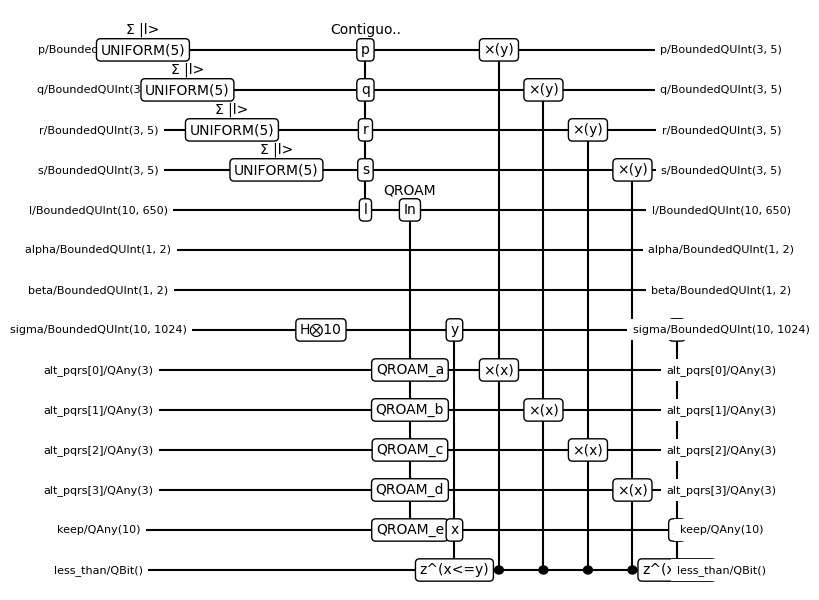

In [10]:
from qualtran.drawing import get_musical_score_data, draw_musical_score
msd = get_musical_score_data(prep.decompose_bloq()) 
fig, ax = draw_musical_score(msd)
fig.set_size_inches(8, 6)

That looks about right. How about our bloq counts:

In [11]:
prep_basic = PrepareSecondQuantization(num_spin_orb).call_graph()[1].get(TGate())
prep_decom = prep.decompose_bloq().call_graph()[1].get(TGate())
print(f"call graph = {prep_basic}, decomposition = {prep_decom}")

call graph = 1348, decomposition = 2284


This is quite a bit different, and stems from the difference between contiguous register (which contributes a relatively large amount for this small system), and, the black box QROAM cost is different from that provided by SelectSwapQROM. Nevertheless, they should exhibit the same asymptotic scaling.

## Exercises:
We left a few errors in our implementation. Can you spot them?

1. What happened to the sign bit? How is this incorporated in state preparation?
2. Think about the range of the selection registers compared to the amount of data we want to load from the contiguous register. Something doesn't add up. Consider Fig. 3 from the [THC paper](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.030305), and the surrounding text on how you might remedy this. An alternative could be to consider the [sparse preparation](sparse/prepare.py).
3. How can we tell what part of the Hamiltonian we prepare (one- or two-body). We need a flag qubit to control off of for [select](sparse/select_bloq.py).

## Doing better

We have achieved an asymptotic speed up for our quantum algorithm. Can we do better? The answer is yes.

1. The two electron integrals are 8-fold symmetric: $V_{pqrs} = V_{qprs} = V_{pqsr} = V_{qpsr} = V_{rspq} = V_{srpq} = V_{srqp} = V_{rsqp}$. So we only need to prepare a fraction (roughly an eight) of the integrals.
2. The two-electron matrix element tensor is sparse, with a sparsity that grows with the system size. Note that to see this sparsity in practice often one has to go to large system sizes (and use a localized basis set). Under these conditions we expect that the number of non-zero elements to scale like $N^3$ rather than $N^4$.

Point 1 reduces our costs by roughly a factor of $8^{1/2}$, at the cost of introducing swaps which are of negligible cost. Point 2. reduces the scaling by a factor of $N$, which when QROAM is taken into account, results in an asymptotic cost of $O(N^{1.5})$.

Let's compare our bloq to that of the sparse prepare bloq:

In [12]:
from qualtran.bloqs.chemistry.sparse.prepare import PrepareSparse
num_bits_state_prep = 4
num_spin_orb = 10
tpq, eris = gen_random_chem_ham(num_spin_orb)
alt_pqrs, keep = build_alt_keep_vals(tpq, eris, num_spin_orb, num_bits_state_prep)
prep = PrepareSecondQuantizationDetailed(num_spin_orb, tuple(alt_pqrs), tuple(keep), num_bits_state_prep=num_bits_state_prep)
prep_sparse = PrepareSparse.from_hamiltonian_coeffs(num_spin_orb, tpq, eris, num_bits_state_prep).decompose_bloq()
print(f"naive = {prep.call_graph()[1].get(TGate())}, sparse = {prep_sparse.call_graph()[1].get(TGate())}")

naive = 1908, sparse = 1079
